In [384]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.ensemble import RandomForestClassifier


In [385]:
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [386]:
# import the shots dataset
shots = pd.read_csv("../datasets/23_24_shotmaps.csv", index_col='Unnamed: 0')

shots = shots.fillna(0)

y = shots.outcome_goal
X = shots[
    [
        "playerCoordinates.x",
        "playerCoordinates.y",
        "playerCoordinates.z",
        "goalMouthCoordinates.x",
        "goalMouthCoordinates.y",
        "goalMouthCoordinates.z",
        "shot_sit_assisted",
        "shot_sit_corner",
        "shot_sit_free-kick",
        "shot_sit_set-piece",
        "bodyPart_left-foot",
        "bodyPart_right-foot",
    ]
]


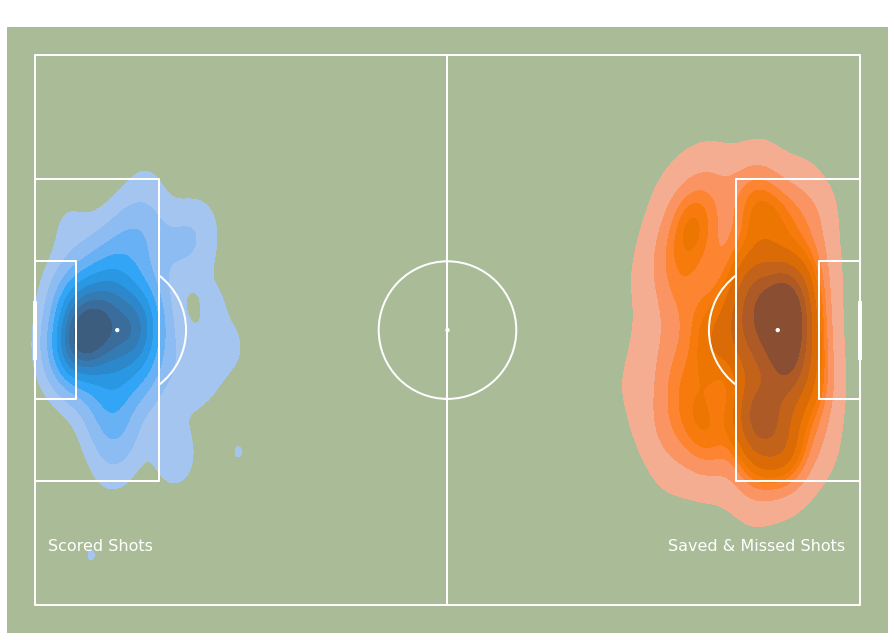

In [387]:
# create a split view plot
pitch = Pitch(
    pitch_color="#aabb97",
    line_color="white",
    stripe=False,
)

fig, ax = pitch.draw(figsize=(16, 9))

sns.kdeplot(
    x=shots[shots["outcome_goal"] == 1]['playerCoordinates.x'] + 2.5,
    y=90 - shots[shots["outcome_goal"] == 1]['playerCoordinates.y'],
    fill=True,
    zorder=-1,
    alpha=1,
    label="Goal",
)

sns.kdeplot(
    x=117.5 - shots[shots["outcome_goal"] == 0]['playerCoordinates.x'],
    y=90 - shots[shots["outcome_goal"] == 0]['playerCoordinates.y'],
    fill=True,
    zorder=-1,
    alpha=1,
    label="No Goal",
)

ax.annotate("Scored Shots", xy=(2, 72), c="White", fontsize=16)
ax.annotate("Saved & Missed Shots", xy=(92, 72), c="White", fontsize=16)

plt.title("Shotmap from Premier League Games 2023-2024 Season", c="White", fontsize=20)

plt.savefig("../assets/shotmap.png")
plt.show()

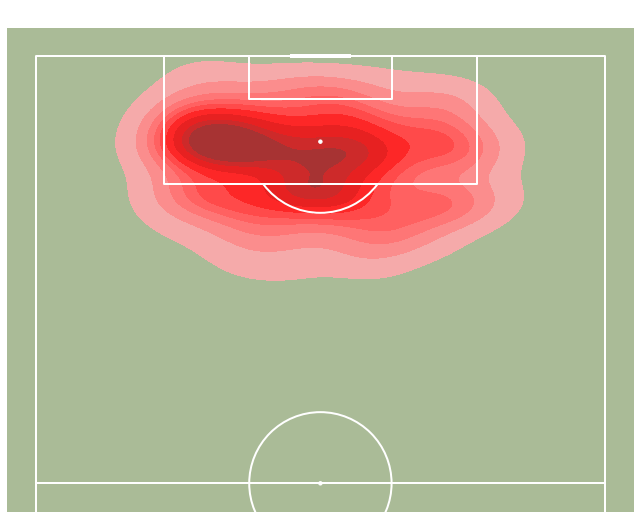

In [388]:
# create a split view plot
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True
)

fig, ax = pitch.draw(figsize=(9, 9))

sns.kdeplot(
    x=shots[shots["outcome_block"] == 1]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_block"] == 1]['playerCoordinates.x'],
    fill=True,
    zorder=-1,
    color='red'
)

plt.title("Density of Blocked Shots from Premier League Games 23/24", c="White", fontsize=20)


plt.savefig("../assets/blocked_map.png")
plt.show()

## Model Architecture & Compiling

In [389]:
tf.random.set_seed(111)

In [390]:
# split the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=111
)

In [391]:
xg_model = keras.Sequential()

xg_model.add(layers.Input(shape=X_train.shape[1]))

xg_model.add(layers.Dense(8, activation="tanh", input_shape=(X_train.shape,)))
xg_model.add(layers.Dense(16, activation="tanh"))
xg_model.add(layers.Dense(32, activation="tanh"))
xg_model.add(layers.Dropout(0.2))
xg_model.add(layers.Dense(64, activation="tanh"))

xg_model.add(layers.Dense(1, activation="sigmoid"))

In [392]:
xg_model.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 8)                 104       
                                                                 
 dense_139 (Dense)           (None, 16)                144       
                                                                 
 dense_140 (Dense)           (None, 32)                544       
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 dense_141 (Dense)           (None, 64)                2112      
                                                                 
 dense_142 (Dense)           (None, 1)                 65        
                                                                 
Total params: 2,969
Trainable params: 2,969
Non-train

In [393]:
xg_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    patience=15,
    mode="min",
    monitor="val_loss",
    restore_best_weights=True,
)
# story history
xg_history = xg_model.fit(
    X_train, y_train, validation_split=0.2, callbacks=callback, epochs=200, verbose=1
)

Epoch 1/200


23/23 [==============================] - 3s 23ms/step - loss: 0.6398 - accuracy: 0.6355 - val_loss: 0.5283 - val_accuracy: 0.8556
Epoch 2/200
23/23 [==============================] - 0s 9ms/step - loss: 0.5089 - accuracy: 0.8170 - val_loss: 0.4013 - val_accuracy: 0.8722
Epoch 3/200
23/23 [==============================] - 0s 8ms/step - loss: 0.4057 - accuracy: 0.8687 - val_loss: 0.3190 - val_accuracy: 0.8833
Epoch 4/200
23/23 [==============================] - 0s 6ms/step - loss: 0.3519 - accuracy: 0.8771 - val_loss: 0.2825 - val_accuracy: 0.8944
Epoch 5/200
23/23 [==============================] - 0s 7ms/step - loss: 0.3318 - accuracy: 0.8799 - val_loss: 0.2670 - val_accuracy: 0.9000
Epoch 6/200
23/23 [==============================] - 0s 7ms/step - loss: 0.3260 - accuracy: 0.8799 - val_loss: 0.2554 - val_accuracy: 0.9000
Epoch 7/200
23/23 [==============================] - 0s 9ms/step - loss: 0.3137 - accuracy: 0.8855 - val_loss: 0.2516 - val_accuracy: 0.8944
Epoch 8/200
23/23 [=====

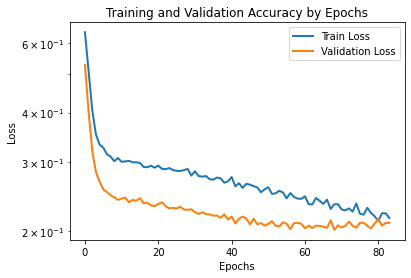

In [394]:
plt.title("Training and Validation Accuracy by Epochs")
plt.semilogy(xg_history.history["loss"], label="Train Loss", linewidth=2)
plt.semilogy(xg_history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Alternate models for comparision

In [503]:
clf = RandomForestClassifier(max_depth=15, random_state=0)
clf.fit(X_train, y_train)

rf_pred = clf.predict_proba(X_scaled)[:,1]

## Generate xG Predictions

In [504]:
# predict on full data
xG_pred = xg_model.predict(X_scaled)
sofa_score_pred = shots[['xg']]

In [505]:
ann_mse = mean_squared_error(y, xG_pred)
rf_mse = mean_squared_error(y, rf_pred)
sofascore_mse = mean_squared_error(y, sofa_score_pred)

print(f'ANN Model MSE: {ann_mse:0.4f}')
print(f'RF Model MSE: {rf_mse:0.4f}')
print(f'Sofascore\'s Model MSE: {sofascore_mse:0.4f}')

ANN Model MSE: 0.0701
RF Model MSE: 0.0228
Sofascore's Model MSE: 0.0746


In [506]:
winner = min(ann_mse, rf_mse)
if ann_mse == min(ann_mse, rf_mse):
    shots["xG_pred"] = xG_pred
else:
    shots['xG_pred'] = rf_pred

## Plot xG by Player Coordinates

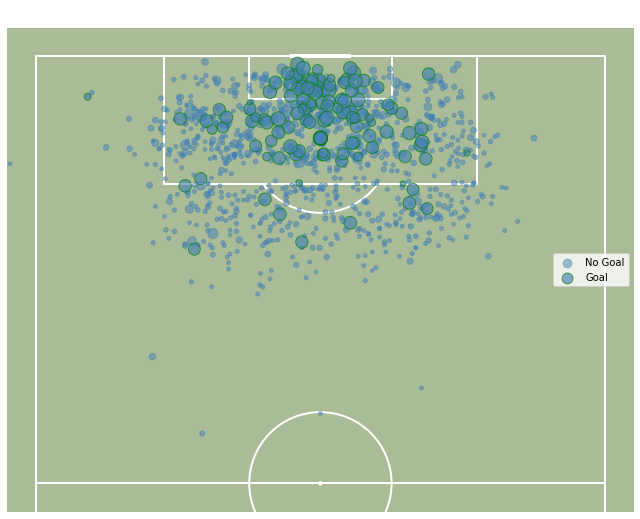

In [507]:
# create a split view plot
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True
)

fig, ax = pitch.draw(figsize=(9, 9))

plt.scatter(
    x=shots[shots["outcome_goal"] == 0]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_goal"] == 0]['playerCoordinates.x'],
    alpha=0.5,
    s=200 * shots[shots["outcome_goal"] == 0].xG_pred + 15,
    c="steelblue",
    label="No Goal",
)

plt.scatter(
    x=shots[shots["outcome_goal"] == 1]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_goal"] == 1]['playerCoordinates.x'],
    alpha=0.65,
    s=200 * shots[shots["outcome_goal"] == 1].xG_pred + 15,
    c="steelblue",
    edgecolor="green",
    label="Goal",
)

plt.title("Shotmap from Premier League Games '2023", c="White", fontsize=20)
plt.legend()

plt.savefig("../assets/xg_map.png")
plt.show()

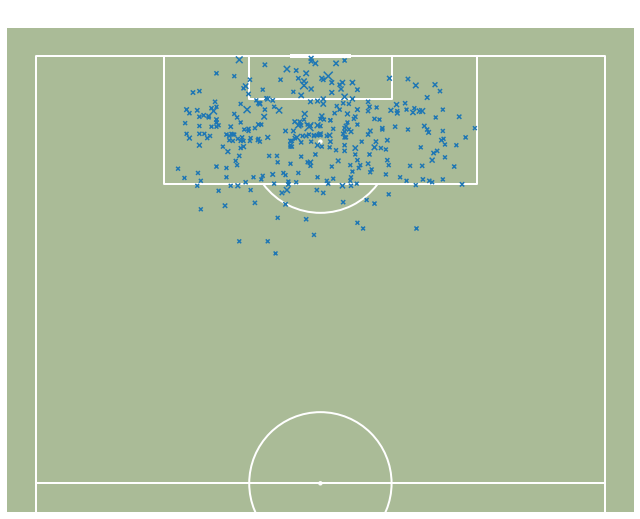

In [508]:
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True
)

fig, ax = pitch.draw(figsize=(9, 9))

plt.scatter(
    x=shots[shots["outcome_block"] == 1]['blockCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_block"] == 1]['blockCoordinates.x'],
    marker='x',
    s=200 * shots[shots["outcome_block"] == 1].xG_pred + 15,
)

plt.title("Map of Blocked Shots from Premier League Games 23/24", c="White", fontsize=20)


plt.savefig("../assets/blocked_map.png")
plt.show()

In [509]:
# plt.scatter(
#     x=shots[shots["outcome_goal"] == 1].goalMouth_z,
#     y=shots[shots["outcome_goal"] == 1].goalMouth_y,
#     label="Goal",
#     alpha=1
# )

# plt.scatter(
#     x=shots[shots["outcome_goal"] == 0].goalMouth_z,
#     y=shots[shots["outcome_goal"] == 0].goalMouth_y,
#     label="Goal",
#     c='red',
#     alpha=0
# )
# plt.xlim(0, 37)
# plt.ylim(44, 56)
# plt.show()

## Compile xG stats by player and team

In [510]:
xg_for = shots.groupby('team')['xG_pred'].sum().sort_values(ascending=False)
xg_against = shots.groupby('opponent')['xG_pred'].sum().sort_values(ascending=False)


xg_table = pd.concat([xg_for, xg_against], axis=1, keys=['xG', 'xGA'])
xg_table['xG_differential'] = xg_table['xG'] - xg_table['xGA']

In [511]:
xg_table = xg_table.sort_values(by='xG_differential', ascending=False)
xg_table['Team'] = xg_table.index
xg_table.reset_index(drop=True, inplace=True)
xg_table.index = range(1, len(xg_table) + 1)

In [512]:
# sort columns alphabetically
desired_columns = sorted([col for col in xg_table.columns])

# Reorder the columns based on the desired order
xg_table = xg_table[desired_columns]

xg_table.to_markdown('../assets/xG_table.md', index=True)
xg_table

,Team,xG,xGA,xG_differential
1,Manchester City,11.110254,2.377689,8.732566
2,Tottenham Hotspur,10.577340,4.736948,5.840392
3,Arsenal,8.430715,3.258565,5.172150
4,Brighton & Hove Albion,10.541920,6.560085,3.981836
5,West Ham United,8.769362,5.248875,3.520487
6,Liverpool,8.189365,5.112691,3.076674
7,Crystal Palace,5.684344,2.851574,2.832770
8,Brentford,8.071483,5.247602,2.823880
9,Chelsea,5.891490,4.813108,1.078381
10,Newcastle United,7.406788,6.365402,1.041387


### Player xG table

In [513]:
xg_by_player = pd.DataFrame(shots.groupby('player.name')['xG_pred'].sum().sort_values(ascending=False))

player_team = shots[['player.name', 'team']].drop_duplicates(subset='player.name')

xg_by_player = xg_by_player.merge(player_team, how='left', left_on='player.name', right_on='player.name')
xg_by_player.reset_index(drop=True, inplace=True)
xg_by_player.index = range(1, len(xg_by_player) + 1)

xg_by_player = xg_by_player.rename(columns={'player.name': 'Player', 'xG_pred': 'xG', 'team': 'Team'})
xg_by_player.head(20).to_markdown('../assets/xG_by_player.md', index=True)
xg_by_player.head(20)

,Player,xG,Team
1,Erling Haaland,5.478179,Manchester City
2,Bryan Mbeumo,3.233611,Brentford
3,Jarrod Bowen,3.202265,West Ham United
4,Evan Ferguson,3.062254,Brighton & Hove Albion
5,Taiwo Awoniyi,2.666667,Nottingham Forest
6,Yoane Wissa,2.476061,Brentford
7,Matty Cash,2.449963,Aston Villa
8,Odsonne Édouard,2.436845,Crystal Palace
9,James Maddison,2.277143,Tottenham Hotspur
10,Alexander Isak,2.170725,Newcastle United


In [514]:
shots.head()

,addedTime,blockCoordinates.x,blockCoordinates.y,blockCoordinates.z,bodyPart,bodyPart_head,bodyPart_left-foot,bodyPart_other,bodyPart_right-foot,draw.block.x,draw.block.y,draw.end.x,draw.end.y,draw.goal.x,draw.goal.y,draw.start.x,draw.start.y,event.awayTeam.name,event.awayTeam.slug,event.homeTeam.name,event.homeTeam.slug,event.id,event.slug,event.winnerCode,goalMouthCoordinates.x,goalMouthCoordinates.y,goalMouthCoordinates.z,goalMouthLocation,goalType,homeTeam_False,homeTeam_True,id,incidentType,isHome,opponent,outcome_block,outcome_goal,outcome_miss,outcome_post,outcome_save,player.firstName,player.id,player.lastName,player.name,player.position,player.shortName,player.slug,player.userCount,playerCoordinates.x,playerCoordinates.y,playerCoordinates.z,reversedPeriodTime,reversedPeriodTimeSeconds,shotType,shot_sit_assisted,shot_sit_corner,shot_sit_fast-break,shot_sit_free-kick,shot_sit_penalty,shot_sit_regular,shot_sit_set-piece,shot_sit_throw-in-set-piece,situation,team,time,timeSeconds,xG_pred,xg,xgot,xG_rf
0,8.0,0.0,0.0,0.0,left-foot,0.0,1,0.0,0,0.0,0.0,42.2,0,42.2,62.5,61.5,18.4,Nottingham Forest,nottingham-forest,Arsenal,arsenal,11352251,arsenal-nottingham-forest,1,0,57.8,37.5,close-left,0,0,1,2137527,shot,True,Nottingham Forest,0,0,1,0.0,0,0,547410,0.0,Martin Ødegaard,M,M. Ødegaard,martin-odegaard,27116,18.4,61.5,0,1,467,miss,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,assisted,Arsenal,90,5833,0.040000,0.049066,0.000,0.040000
1,5.0,0.0,0.0,0.0,right-foot,0.0,0,0.0,1,0.0,0.0,58.2,0,58.2,50.0,50.7,22.8,Nottingham Forest,nottingham-forest,Arsenal,arsenal,11352251,arsenal-nottingham-forest,1,0,41.8,50.0,close-high-right,0,1,0,2137521,shot,False,Arsenal,0,0,1,0.0,0,0,45944,0.0,Cheikhou Kouyaté,M,C. Kouyaté,cheikhou-kouyate,3036,22.8,50.7,0,1,603,miss,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,set-piece,Nottingham Forest,90,5697,0.060000,0.022390,0.000,0.060000
2,3.0,17.7,39.5,0.0,left-foot,0.0,1,0.0,0,39.5,17.7,47.1,0,47.1,81.0,37.4,22.7,Nottingham Forest,nottingham-forest,Arsenal,arsenal,11352251,arsenal-nottingham-forest,1,0,52.9,19.0,low-left,0,0,1,2137518,shot,True,Nottingham Forest,1,0,0,0.0,0,0,547410,0.0,Martin Ødegaard,M,M. Ødegaard,martin-odegaard,27116,22.7,37.4,0,1,728,block,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,fast-break,Arsenal,90,5572,0.010000,0.035848,0.000,0.010000
3,0.0,1.4,49.6,0.0,left-foot,0.0,1,0.0,0,49.6,1.4,49.4,0,49.4,96.2,47.9,8.8,Nottingham Forest,nottingham-forest,Arsenal,arsenal,11352251,arsenal-nottingham-forest,1,0,50.6,3.8,low-centre,0,0,1,2137499,shot,True,Nottingham Forest,0,0,0,0.0,1,0,934235,0.0,Bukayo Saka,F,B. Saka,bukayo-saka,38508,8.8,47.9,0,4,189,save,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,assisted,Arsenal,87,5211,0.166111,0.126313,0.058,0.166111
4,0.0,4.9,66.8,0.0,right-foot,0.0,0,0.0,1,66.8,4.9,48.3,0,48.3,81.0,69.9,5.7,Nottingham Forest,nottingham-forest,Arsenal,arsenal,11352251,arsenal-nottingham-forest,1,0,51.7,19.0,low-centre,0,0,1,2137492,shot,True,Nottingham Forest,1,0,0,0.0,0,0,836705,0.0,Kai Havertz,F,K. Havertz,kai-havertz,38704,5.7,69.9,0,6,343,block,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,assisted,Arsenal,85,5057,0.010000,0.020508,0.000,0.010000
